In [1]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
#import seaborn as sns
import xlsxwriter
import scipy.stats as stats
import os,sys
import pickle
import random
import math
import time
import numpy as np
from mpl_toolkits.basemap import Basemap
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon, Rectangle
from collections import OrderedDict
import pandas as pd
import shapefile as shp
import geopandas as gpd
from matplotlib.colors import rgb2hex, Normalize
from matplotlib.colorbar import ColorbarBase
from matplotlib.cm import ScalarMappable
from get_population_by_state import GetAgeSex
import seaborn as sns

In [2]:
measurement_type = 'no2'
fname = "output_files/PR_IR_AF_2010_2019_{}_just_epa.csv".format(measurement_type)
national_file = "output_files/national_avg_df.csv"
state_shape_file = "data/basemap/cb_2018_us_state_5m"
epa_region = "data/state_code_to_region_mapping.csv"
pr_ir_file = "output_files/PR_IR_2010_2019_with_na.csv"
pr_ir_df = pd.read_csv(pr_ir_file)

In [39]:
def draw_us_map(plt,pop_lookup, df, col, title='2019', adjust=True, 
                cmap_title='2019', annot='a)'):
    # Set the lower left and upper right limits of the bounding box:
    lllon = -119
    urlon = -64
    lllat = 22.0
    urlat = 50.5
    # and calculate a centerpoint, needed for the projection:
    centerlon = float(lllon + urlon) / 2.0
    centerlat = float(lllat + urlat) / 2.0

    m = Basemap(resolution='h',  # crude, low, intermediate, high, full
                llcrnrlon = lllon, urcrnrlon = urlon,
                lon_0 = centerlon,
                llcrnrlat = lllat, urcrnrlat = urlat,
                lat_0 = centerlat,
                projection='tmerc')
    shp_info = m.readshapefile(state_shape_file, 'states',
                               drawbounds=True, color='lightgrey')
    
    EXCLUDE = ['United States Virgin Islands','Puerto Rico', 
               "Guam", 'Commonwealth of the Northern Mariana Islands', 'American Samoa']
    colors={}
    statenames=[]
    if "trend" in cmap_title.lower():
        cmap = plt.get_cmap("coolwarm")
    else:
        cmap = plt.get_cmap("Reds")    
    l = df[col].tolist()
    if adjust:
        vmin, vmax =np.percentile(l, 5), np.percentile(l, 85)
        vmin, vmax = -0.9, 0.9
    else:
        vmin, vmax = np.nanmin(l), np.nanmax(l)
    print(vmin, vmax)
    norm = Normalize(vmin=vmin, vmax=vmax)
    mapper = ScalarMappable(norm=norm, cmap=cmap)
    for shapedict in m.states_info:
        statename = shapedict['NAME']
        if statename not in EXCLUDE:
            try:
                pop = pop_lookup[statename]
                colors[statename] = mapper.to_rgba(pop)
            except:
                pass
        statenames.append(statename)
        
    ax = plt.gca() # get current axes instance
    ax.text(0.01, 1, annot, transform=ax.transAxes, size=16, color='black')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)    
    

    for nshape,seg in enumerate(m.states):
        if statenames[nshape] == 'Alaska':
        # Alaska is too big. Scale it down to 35% first, then transate it. 
            seg = [(0.35*i[0]+ 1600000, 0.35*i[1]-1830000) for i in seg]
        if statenames[nshape] == 'Hawaii':
            seg = [(i[0]+ 5750000, i[1]-1500000) for i in seg]
        if statenames[nshape] not in EXCLUDE:
            try:
                color = rgb2hex(colors[statenames[nshape]]) 
                poly = Polygon(seg,facecolor=color,edgecolor=color)
                ax.add_patch(poly)
            except:
                pass
    plt.title(title, size=16)
    fig = plt.gcf()

    cax = fig.add_axes([0.25,0.08, 0.5, 0.05]) # posititon
    cb = ColorbarBase(cax,cmap=cmap,norm=norm, orientation='horizontal')
    cb.ax.set_xlabel(cmap_title, fontsize=12)
    if "Trend" in cmap_title:
        shift = 0
        cb.ax.set_xticks([vmin/2-shift, vmax/2-shift], ["$\it{decreasing}$",  "$\it{increasing}$"])
    plt.savefig("output_images/{}.png".format(cmap_title.replace(" ", "_")), bbox_inches='tight', dpi=600)
    plt.show()
    return m, shp_info


def cal_corr(row):
    col = row['SAF']
    years = row['year']
#     reliability = row['reliability']
    x = [i for i in col]
    y = [i for i in years]
    if len(x)>=2:
        start, end = [i for i in x if i][0], x[-1]
        if start != end:
            return (end-start)/start
        return np.nan
#     if len(x)>=4:
#         return np.corrcoef(x,y)[0][1]
    else:
        return np.nan

def plot_basemap(plt,df, year, col, state_name = 'NAME', annot='a)', 
                 cmap_title=None, title=None, adjust=True):
    if 'trend' not in cmap_title.lower():
        df = df[df['year']==int(year)]
        df[col] = df[col]*100
    else:
#         df = df[df['year']>=2013]
        df = df.groupby(['state_code']).agg({'State Name': 'first', 'AC': list,'year':list, 'SAF': list}).reset_index()
        df[col] = df.apply(cal_corr, axis=1)
    pop_lookup = {row[state_name]: row[col] for index, row in df.iterrows()}
    try:
        pop_lookup['District of Columbia'] = pop_lookup['District Of Columbia']
    except:
        pass
    draw_us_map(plt,pop_lookup, df, col, annot=annot, cmap_title=cmap_title, 
                       title=title, adjust=adjust)
    return df

        State Name       corr
0          Alabama   0.022191
2          Arizona   0.025569
5         Colorado   0.079794
9          Florida   0.333073
10         Georgia   1.636249
11          Hawaii   0.192935
17        Kentucky   2.353263
18       Louisiana   0.122720
20        Maryland   0.480541
21   Massachusetts   0.131618
22        Michigan   0.355993
23       Minnesota   2.051592
24     Mississippi   1.869175
27          Nevada   0.506455
29      New Jersey   0.105219
32  North Carolina   0.805073
34            Ohio   0.300861
35        Oklahoma   0.179560
36          Oregon   0.906121
38    Rhode Island   0.789842
40    South Dakota   0.177310
41       Tennessee   0.999660
42           Texas   0.012724
43            Utah   0.070637
45        Virginia   0.797868
46      Washington  53.602759
47       Wisconsin   0.072954
48         Wyoming   1.337549
-0.9 0.9


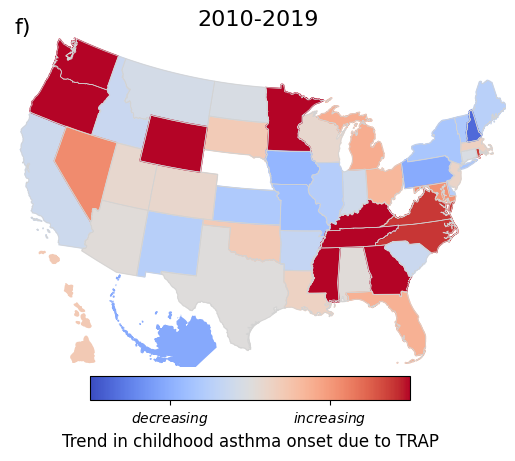

,state_code,State Name,AC,year,SAF,corr,first_year,last_year,first_saf,last_saf
0,1.0,Alabama,"[257.5838149258344, 362.0140156229815, 280.350...","[2013, 2014, 2015, 2016, 2017, 2018, 2019]","[0.0305516996667361, 0.0369814037290393, 0.033...",0.022191,2013,2019,3.06,3.12
1,2.0,Alaska,"[46.20612156356891, 28.732303180905145, 42.583...","[2014, 2015, 2016, 2017, 2018, 2019]","[0.027937876714083, 0.020626342170874, 0.02768...",-0.481958,2014,2019,2.79,1.45
2,4.0,Arizona,"[4546.366503204377, 4171.246337535512, 4410.05...","[2010, 2011, 2012, 2013, 2014, 2015, 2016, 201...","[0.2935580072176632, 0.3114556366502009, 0.314...",0.025569,2010,2019,29.36,30.11
3,5.0,Arkansas,"[178.8019151763691, 165.02655353961845, 180.98...","[2010, 2011, 2012, 2013, 2014, 2015, 2016, 201...","[0.0262927558863718, 0.0281261596204146, 0.029...",-0.156019,2010,2019,2.63,2.22
4,6.0,California,"[55119.32276765073, 32115.528988374204, 32987....","[2010, 2011, 2012, 2013, 2014, 2015, 2016, 201...","[0.3092379586070044, 0.2970739119504436, 0.305...",-0.109005,2010,2019,30.92,27.55
5,8.0,Colorado,"[930.2559375643598, 773.8436114688772, 892.824...","[2010, 2011, 2012, 2013, 2014, 2015, 2016, 201...","[0.0793226168318519, 0.0761480038335084, 0.083...",0.079794,2010,2019,7.93,8.57
6,9.0,Connecticut,"[974.6481309312107, 880.7655209999307, 318.553...","[2010, 2011, 2012, 2013, 2014, 2015, 2016, 201...","[0.1600507323262791, 0.1603302349387715, 0.145...",-0.029415,2010,2019,16.01,15.53
7,10.0,Delaware,"[279.7595917335664, 210.6488637383242, 234.672...","[2010, 2011, 2012, 2013, 2014, 2015, 2016, 201...","[0.1424451073706766, 0.1247528101740076, 0.133...",-0.233454,2010,2019,14.24,10.92
8,11.0,District Of Columbia,"[274.9612838865656, 241.44691744683013, 266.54...","[2010, 2011, 2012, 2013, 2014, 2015, 2016, 201...","[0.3128411098612013, 0.2937546363112718, 0.303...",-0.162199,2010,2019,31.28,26.21
9,12.0,Florida,"[2559.626138070979, 2393.5039980811384, 2233.3...","[2010, 2011, 2012, 2013, 2014, 2015, 2016, 201...","[0.0713984714936126, 0.0667374479051942, 0.062...",0.333073,2010,2019,7.14,9.52


In [38]:
cmap_title = 'Trend in childhood asthma onset due to TRAP'
title = '2010-2019'
col = 'corr'
vvdf = plot_basemap(plt, original_df, '2019', col, state_name='State Name', annot='f)', 
                  cmap_title=cmap_title, title=title, adjust=True)

vvdf['first_year'] = vvdf['year'].apply(lambda x:x[0])
vvdf['last_year'] = vvdf['year'].apply(lambda x:x[-1])
vvdf['first_saf'] = vvdf['SAF'].apply(lambda x:"{0:.2f}".format(x[0]*100))
vvdf['last_saf'] = vvdf['SAF'].apply(lambda x:"{0:.2f}".format(x[-1]*100))
columns = ['State Name', 'first_year', 'first_saf', 'last_year', 'last_saf', 'corr']
# vvdf.sort_values(by='corr', ascending=False, inplace=True)
vvdf[columns].to_csv("output_files/trend_in_af.csv", index=False)
vvdf

C:\Users\harsh\AppData\Local\Temp\ipykernel_37528\1667331569.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col]*100


0.36491025565414004 34.43415111044057


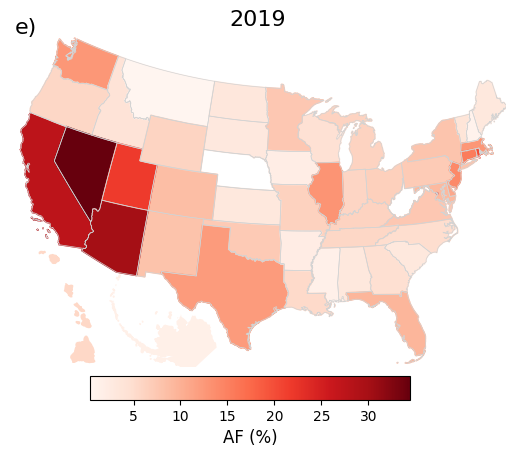

In [34]:
cmap_title = 'AF (%)'
title = '2019'
col = 'SAF'
vvdf = plot_basemap(plt,original_df, '2019', col, state_name='State Name', annot='e)', 
                  cmap_title=cmap_title, title=title, adjust=False)

In [5]:
epa_region_df = pd.read_csv(epa_region)
original_df = pd.read_csv(fname)
original_df = original_df.merge(epa_region_df[['State Code', 'State Name']], left_on='state_code', right_on='State Code', how='left')
syear = 2010

df = original_df[(original_df['year']>=syear) & (original_df['State Code'] !=0)]

n_df = pd.read_csv(national_file)
n_df = n_df[n_df['year']>=syear]
n_df = n_df[n_df['measurement_type'] == measurement_type]

tn_df = df.groupby(['year']).agg({'incidence_cases': 'sum', 'AC': 'sum', 'AC_5': 'sum', 'AC_95': 'sum'}).reset_index()
tn_df['SAF'] = tn_df['AC']/tn_df['incidence_cases']
tn_df['SAF_5'] = tn_df['AC_5']/tn_df['incidence_cases']
tn_df['SAF_95'] = tn_df['AC_95']/tn_df['incidence_cases']
tn_df

n_df = n_df.merge(tn_df, on='year')

In [ ]:
# n_df['at_risk'] = n_df['population']*(1-n_df['PR'])
# n_df['inc'] = n_df['at_risk']*n_df['IR']
# n_df['ACF'] = n_df['inc']*n_df['SAF']
# n_df['ACF_5'] = n_df['inc']*n_df['SAF_5']
# n_df['ACF_95'] = n_df['inc']*n_df['SAF_95']
# n_df[['year', 'inc', 'SAF', 'SAF_5', 'SAF_95', 'AC', 'AC_5', 'AC_95']]

In [ ]:
df['PR_en'] = df['PR'].apply(lambda x: float("{0:.2f}".format(x*100)))
df['IR_en'] = df['IR'].apply(lambda x: float("{0:.2f}".format(x*1000)))
df['SAF_en'] = df['SAF'].apply(lambda x: float("{0:.2f}".format(x*100)))


n_df['PR_en'] = n_df['PR'].apply(lambda x: float("{0:.2f}".format(x*100)))
n_df['IR_en'] = n_df['IR'].apply(lambda x: float("{0:.2f}".format(x*1000)))

In [ ]:
mdf = df.groupby(['year']).agg({'PR_en': list, 'IR_en': list, 'SAF_en': list, 'AC': list}).reset_index()

# filtr = (pr_ir_df['year']>=2013) & (pr_ir_df['_STATE']!=0)
filtr = (pr_ir_df['_STATE']!=0)

pr_ir_df = pr_ir_df[filtr]
cmdf = pr_ir_df.groupby('year').agg({'PR': list, 'IR':list})
cmdf['PR_en'] = cmdf['PR'].apply(lambda x: [i*100 for i in x if not pd.isna(i)])
cmdf['IR_en'] = cmdf['IR'].apply(lambda x: [i*1000 for i in x if not pd.isna(i)])

In [ ]:
sns.set_style("white")
cmap = plt.get_cmap("Blues")
cmap_target = 0.75
# color=

plt.figure(figsize=(9, 6), dpi=800)
gs = gridspec.GridSpec(2, 2)
annot_size = 12

#####
ax = plt.subplot(gs[0, 0])
ax.text(-0.1, 1, "a)", transform=ax.transAxes, size=annot_size, color='black')

plt.boxplot(cmdf['PR_en'].tolist(), sym='', patch_artist=True, medianprops=dict(color='white'))
plt.plot(range(1,len(n_df['year'])+1), n_df['PR_en'], color='red', linestyle='--', label='National', linewidth=0.7)
plt.xticks([i+1 for i,j in enumerate(mdf['year'].tolist())], mdf['year'])
plt.ylabel("Prevalence per 100 children")
plt.title("Prevalence rate")
sns.despine()
plt.legend(loc='upper right', frameon=False)

###
ax = plt.subplot(gs[0, 1])
ax.text(-0.1, 1, "b)", transform=ax.transAxes, size=annot_size, color='black')
plt.boxplot(cmdf['IR_en'].tolist(),sym='', patch_artist=True, medianprops=dict(color='white'), notch=False)
plt.plot(range(1,len(n_df['year'])+1), n_df['IR_en'], color='red', linestyle='--', label='National', linewidth=0.7)
plt.xticks([i+1 for i,j in enumerate(mdf['year'].tolist())], mdf['year'])
plt.ylabel("Incidence per 1000 children")
plt.title("Incidence rate")
sns.despine()
plt.legend(loc='upper right', frameon=False)

###
ax = plt.subplot(gs[1, 0])
ax.text(-0.11, 1, "c)", transform=ax.transAxes, size=annot_size, color='black')
plt.boxplot(mdf['SAF_en'].tolist(),sym='', patch_artist=True, medianprops=dict(color='white'), notch=False)
x = range(1,len(n_df['year'])+1)
plt.plot(x, n_df['SAF']*100, color='red', linestyle='--', label='National', linewidth=0.7)
plt.fill_between(x, n_df['SAF_5']*100, n_df['SAF_95']*100, color='red', alpha=0.1, label='95% CI')
plt.xticks([i+1 for i,j in enumerate(mdf['year'].tolist())], mdf['year'])
plt.legend(loc='upper right', frameon=False)
plt.title("Percentage attributed to TRAP (AF)")
plt.ylim(0,30)
plt.ylabel("%")
sns.despine()

###
ax = plt.subplot(gs[1, 1])
ax.text(-0.1, 1, "d)", transform=ax.transAxes, size=annot_size, color='black')
# fdf = original_df[original_df['year']>=2013].groupby('year').agg({'AC': 'sum', 'AC_5': 'sum', 'AC_95': 'sum'}).reset_index()
fdf = original_df.groupby('year').agg({'AC': 'sum', 'AC_5': 'sum', 'AC_95': 'sum'}).reset_index()

std = [j-i for i, j in zip(fdf['AC'].tolist(), fdf['AC_95'].tolist())]
x, y = fdf['year'].tolist(), fdf['AC'].tolist()
cum_y = np.cumsum(y)
plt.bar(x, y, color=cmap(0.77))
plt.plot(x, cum_y, color=cmap(0.77))
plt.scatter(x, cum_y, label="Cumulative", s=8, color=cmap(0.77))
ax.ticklabel_format(useOffset=False,style='plain')

flag = 1
for pos, h, err in zip(x, y, std):
    if flag == 1:
        plt.errorbar(pos, h, err, lw = 0.6, color = 'r', alpha=0.3, label='95% CI')
        flag = 0
    else:
        plt.errorbar(pos, h, err, lw = 0.6, color = 'r', alpha=0.3)

plt.xticks(x, mdf['year'])
plt.legend(loc='upper left', frameon=False)
plt.title("Incidences due to TRAP")
plt.ylabel("Number of children")
sns.despine()

plt.suptitle("Statewide distribution of childhood asthma")

plt.tight_layout()
# plt.savefig("output_images/Fig_2_v3.png",bbox_inches='tight')
plt.show()

In [ ]:
import numpy as np
np.cumsum([1,2,3])

In [ ]:
original_df[original_df['state_code'] == 0]

In [ ]:
mdf

In [ ]:
1/-0.13

In [ ]:
1/-0.06